In [1]:
import numpy as np
import pandas as pd
import pysindy as ps
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from sysidentpy.utils.display_results import results
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial

# To have the Matplotlib plots centered in the notebook
from IPython.core.display import HTML
HTML("""
    <style>
    .output_png {
        display: table-cell;
        text-align: center;
        vertical-align: middle;
    }
    </style>
    """)

$$\Large\text{Linear 2D ODE}$$
$$\large \dot{x} = -0.1x + 2y$$
$$\large \dot{y} = -2x - 0.1y$$

$$\large \dot{x} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} x \qquad x \in \R^2$$

$$\large\begin{split}\frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x \\ y\end{bmatrix}\end{split}$$

In [2]:
def f(x, t):
    return [-0.1 * x[0] + 2 * x[1],
            -2 * x[0] - 0.1 * x[1]]

t = np.arange(0, 25, 0.01)
x = odeint(f, [2, 0], t)

# Split Gnerated Data into Train-Test
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.75, shuffle=False)

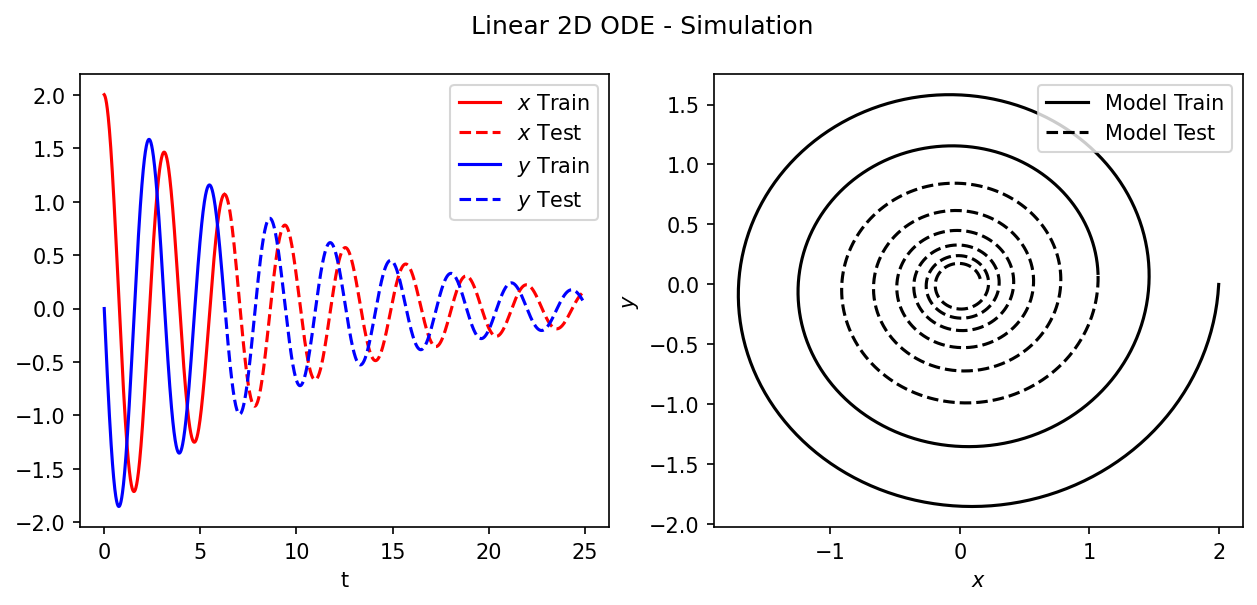

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 2D ODE - Simulation')
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [4]:
# Define SINDy Model
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['x', 'y']
)
# Fit and print resulting model
sindy_model.fit(x_train, t=t_train, quiet=True)
sindy_model.print()

# Simulate SINDy on the test data
x_sim = sindy_model.simulate(x_test[0], t_test)

x' = -0.100 x + 2.000 y
y' = -2.000 x + -0.100 y


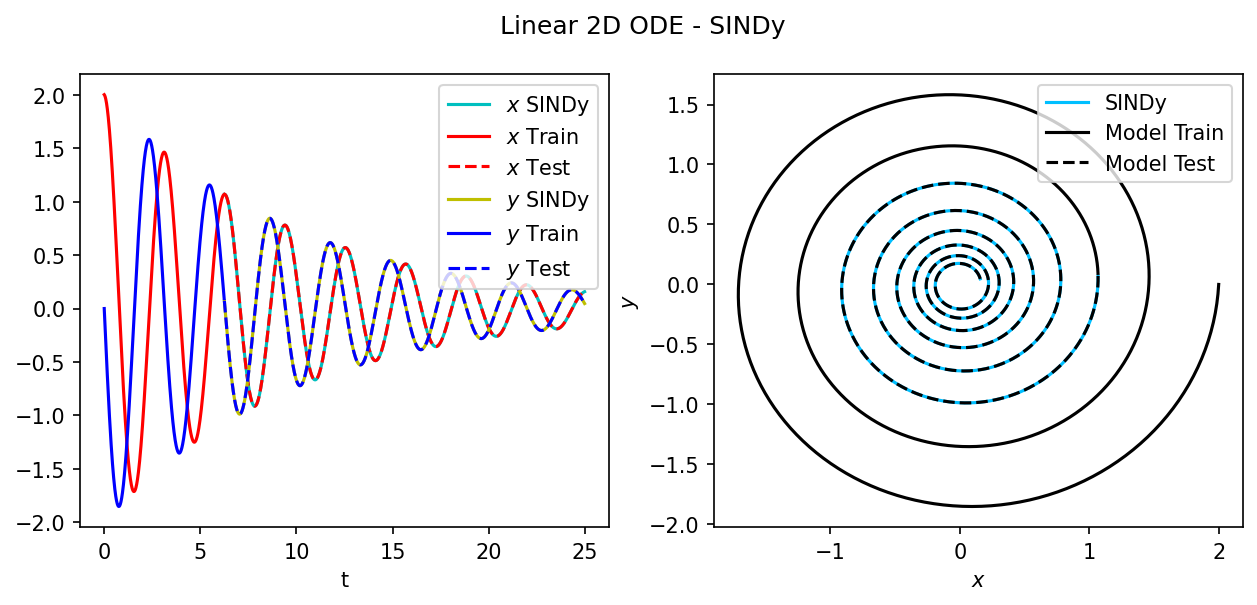

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 2D ODE - SINDy')
axs[0].plot(t_test, x_sim[:, 0], "c", label="$x$ SINDy")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, x_sim[:, 1], "y", label="$y$ SINDy")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "deepskyblue", label="SINDy")
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [6]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
narmax_model = FROLS(
    n_terms=2,
    ylag=1, xlag=1,
    estimator='least_squares',
    basis_function=Polynomial(degree=5)
)
narmax_model.fit(X=x_train[:-1,0].reshape(-1, 1), y=x_train[1:,1].reshape(-1, 1))
r = pd.DataFrame(results(
    narmax_model.final_model, narmax_model.theta, narmax_model.err,
    narmax_model.n_terms, err_precision=8, dtype='sci'), columns=['Regressors', 'Parameters', 'ERR'])
print('Regressors Y')
print(r)
x_sim_y = narmax_model.predict(X=x_test[:,0].reshape(-1, 1), y=x_test[0,1].reshape(-1, 1))

narmax_model.fit(X=x_train[:-1,1].reshape(-1, 1), y=x_train[1:,0].reshape(-1, 1))
r = pd.DataFrame(results(
    narmax_model.final_model, narmax_model.theta, narmax_model.err,
    narmax_model.n_terms, err_precision=8, dtype='sci'), columns=['Regressors', 'Parameters', 'ERR'])
print('Regressors X')
print(r)
x_sim_x = narmax_model.predict(X=x_test[:,1].reshape(-1, 1), y=x_test[0,0].reshape(-1, 1))

x_sim = np.hstack((x_sim_x, x_sim_y))

Regressors Y
  Regressors   Parameters             ERR
0     y(k-1)   9.9840E-01  9.99604055E-01
1    x1(k-1)  -1.9963E-02  3.95944525E-04
Regressors X
  Regressors  Parameters             ERR
0     y(k-1)  9.9840E-01  9.99598063E-01
1    x1(k-1)  1.9963E-02  4.01937372E-04


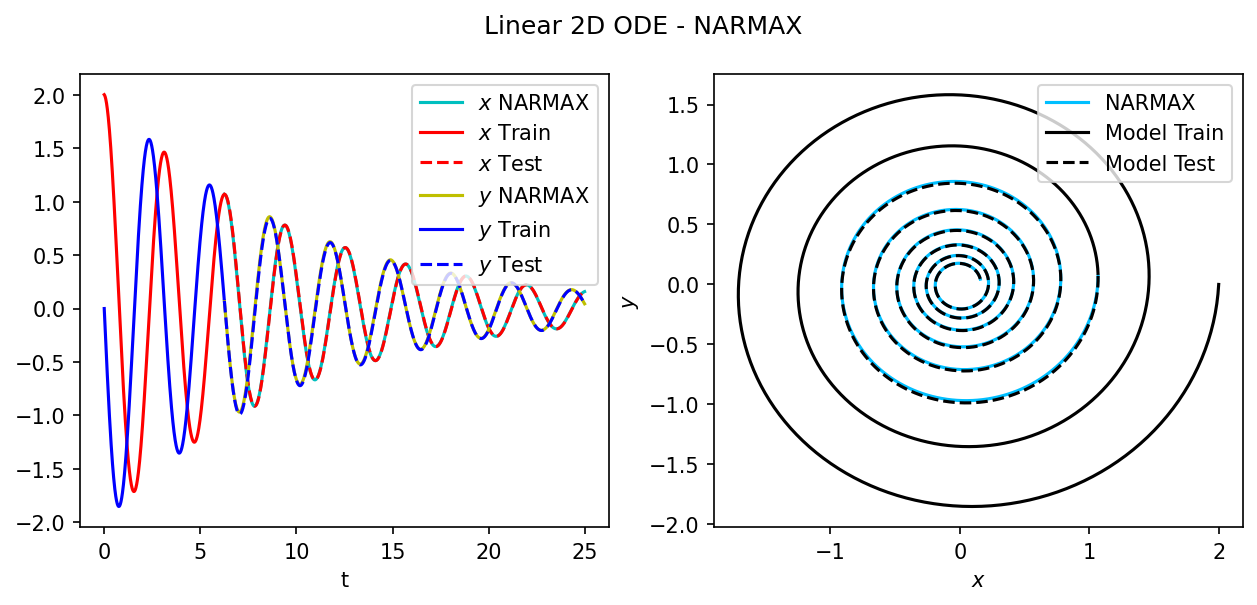

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 2D ODE - NARMAX')
axs[0].plot(t_test, x_sim[:, 0], "c", label="$x$ NARMAX")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, x_sim[:, 1], "y", label="$y$ NARMAX")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "deepskyblue", label="NARMAX")
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [8]:
# Metrics (PENDING!!!)

$$\Large\text{Cubic 2D ODE}$$
$$\large \dot{x} = -0.1x^3 + 2y^3$$
$$\large \dot{y} = -2x^3 - 0.1y^3$$

$$\large \dot{x} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} x^3 \qquad x \in \R^2$$

$$\large\begin{split}\frac{d}{dt}\begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix}-0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x^3 \\ y^3\end{bmatrix}\end{split}$$

In [9]:
def f(x, t):
    return [-0.1 * x[0]**3 + 2 * x[1]**3,
            -2 * x[0]**3 - 0.1 * x[1]**3]

t = np.arange(0, 25, 0.01)
x = odeint(f, [2, 0], t)

# Split Gnerated Data into Train-Test
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.75, shuffle=False)

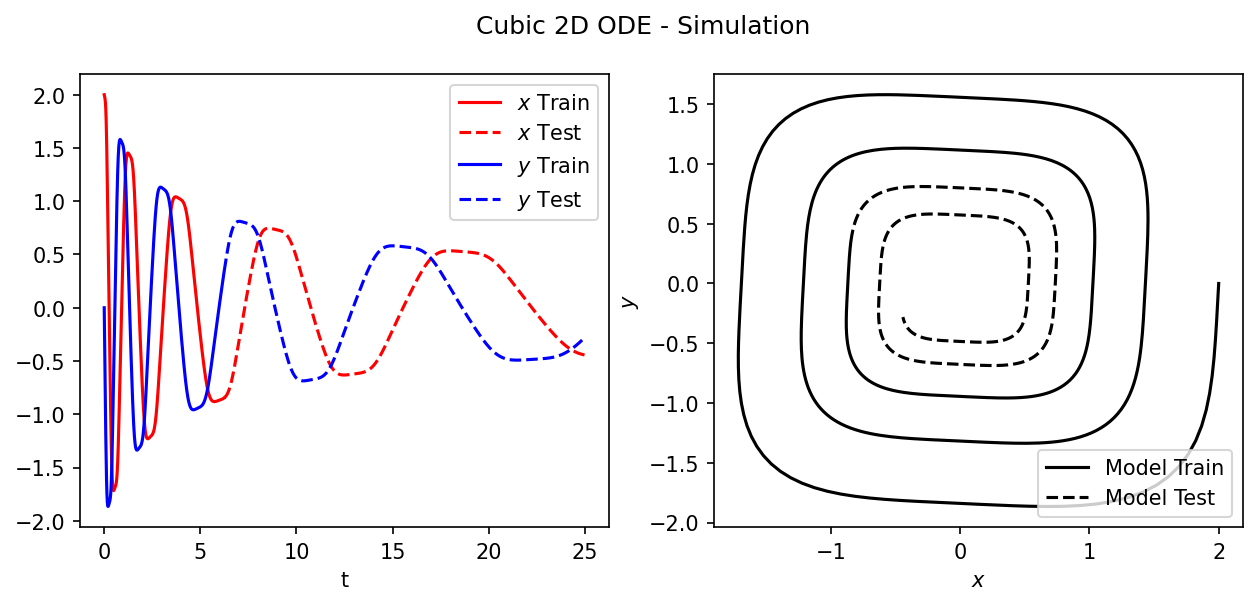

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Cubic 2D ODE - Simulation')
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [11]:
# Define SINDy Model
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.05),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['x', 'y']
)
# Fit and print resulting model
sindy_model.fit(x_train, t=t_train, quiet=True)
sindy_model.print()

# Simulate SINDy on the test data
x_sim = sindy_model.simulate(x_test[0], t_test)

x' = -0.100 x^3 + 1.999 y^3
y' = -1.999 x^3 + -0.100 y^3


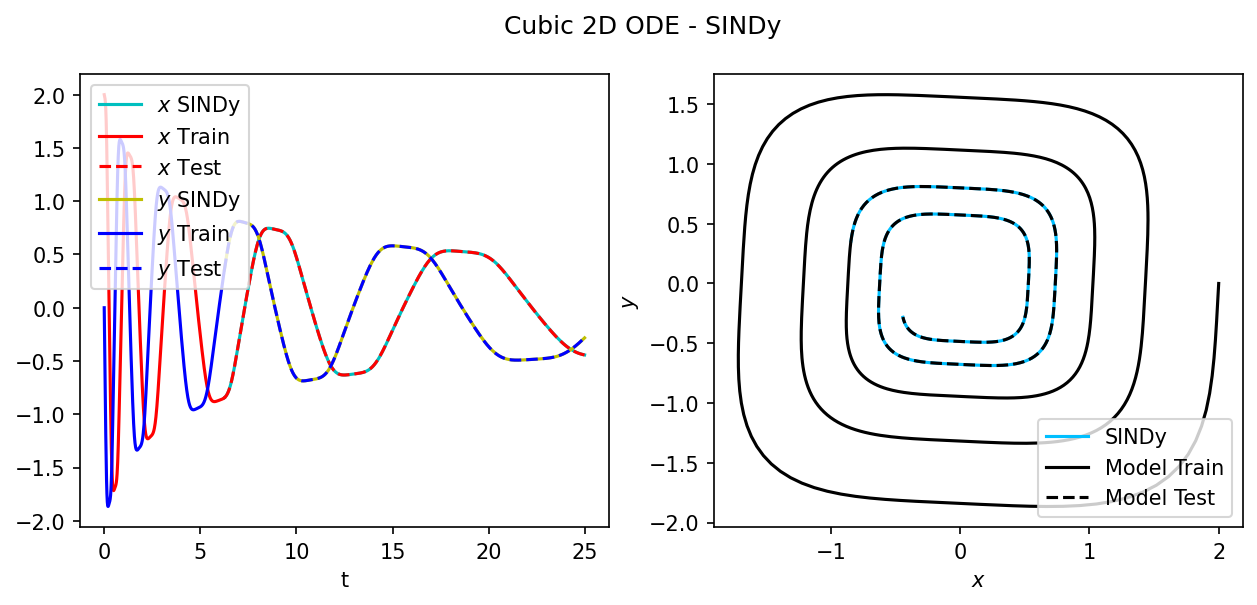

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Cubic 2D ODE - SINDy')
axs[0].plot(t_test, x_sim[:, 0], "c", label="$x$ SINDy")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, x_sim[:, 1], "y", label="$y$ SINDy")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "deepskyblue", label="SINDy")
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [13]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
narmax_model = FROLS(
    n_terms=5,
    ylag=1, xlag=1,
    estimator='least_squares',
    basis_function=Polynomial(degree=5)
)
narmax_model.fit(X=x_train[:-1,0].reshape(-1, 1), y=x_train[1:,1].reshape(-1, 1))
r = pd.DataFrame(results(
    narmax_model.final_model, narmax_model.theta, narmax_model.err,
    narmax_model.n_terms, err_precision=8, dtype='sci'), columns=['Regressors', 'Parameters', 'ERR'])
print('Regressors Y')
print(r)
x_sim_y = narmax_model.predict(X=x_test[:,0].reshape(-1, 1), y=x_test[0,1].reshape(-1, 1))

narmax_model.fit(X=x_train[:-1,1].reshape(-1, 1), y=x_train[1:,0].reshape(-1, 1))
r = pd.DataFrame(results(
    narmax_model.final_model, narmax_model.theta, narmax_model.err,
    narmax_model.n_terms, err_precision=8, dtype='sci'), columns=['Regressors', 'Parameters', 'ERR'])
print('Regressors X')
print(r)
x_sim_x = narmax_model.predict(X=x_test[:,1].reshape(-1, 1), y=x_test[0,0].reshape(-1, 1))

x_sim = np.hstack((x_sim_x, x_sim_y))

Regressors Y
          Regressors   Parameters             ERR
0             y(k-1)   9.9997E-01  9.98639695E-01
1          x1(k-1)^3  -1.9757E-02  1.35079734E-03
2  x1(k-1)^2y(k-1)^3  -1.7867E-03  8.75196741E-06
3           y(k-1)^3  -9.9413E-04  6.03863325E-07
4    x1(k-1)y(k-1)^4  -1.7629E-04  1.32486255E-07
Regressors X
          Regressors   Parameters             ERR
0             y(k-1)   1.0001E+00  9.98664452E-01
1          x1(k-1)^3   1.9763E-02  1.32581507E-03
2  x1(k-1)^2y(k-1)^3  -1.7890E-03  8.67369965E-06
3           y(k-1)^3  -1.0459E-03  9.08592850E-07
4    x1(k-1)y(k-1)^4   1.7654E-04  1.36154763E-07


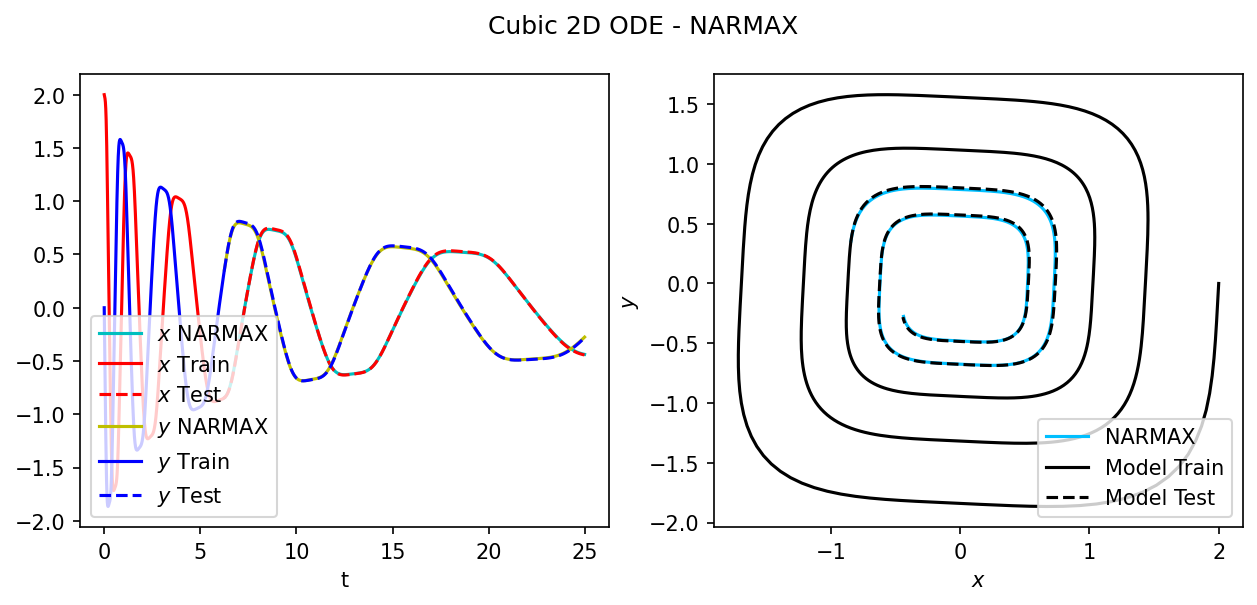

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Cubic 2D ODE - NARMAX')
axs[0].plot(t_test, x_sim[:, 0], "c", label="$x$ NARMAX")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, x_sim[:, 1], "y", label="$y$ NARMAX")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1].plot(x_sim[:, 0], x_sim[:, 1], "deepskyblue", label="NARMAX")
axs[1].plot(x_train[:, 0], x_train[:, 1], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$")
axs[1].legend()
print(end='')

In [ ]:
# Metrics (PENDING!!!)

$$\Large\text{Linear 3D ODE}$$
$$\large \dot{x} = -0.1x + 2y$$
$$\large \dot{y} = -2x - 0.1y$$
$$\large \dot{z} = -0.3z$$

$$\large \dot{x} = \begin{bmatrix} -0.1 & 2 & 0\\ -2 & -0.1 & 0\\ 0 & 0 & -0.3\end{bmatrix} x \qquad x \in \R^2$$

$$\large\begin{split}\frac{d}{dt}\begin{bmatrix}x \\ y \\ z \end{bmatrix} = \begin{bmatrix}-0.1 & -2 & 0 \\ 2 & -0.1 & 0 \\ 0 & 0 & -0.3 \end{bmatrix} \begin{bmatrix}x \\ y \\ z \end{bmatrix}\end{split}$$

In [15]:
def f(x, t):
    return [-0.1 * x[0] + 2 * x[1],
            -2 * x[0] - 0.1 * x[1],
            -0.3 * x[2]]

t = np.arange(0, 50, 0.01)
x = odeint(f, [2, 0, 1], t)

# Split Gnerated Data into Train-Test
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.6, shuffle=False)

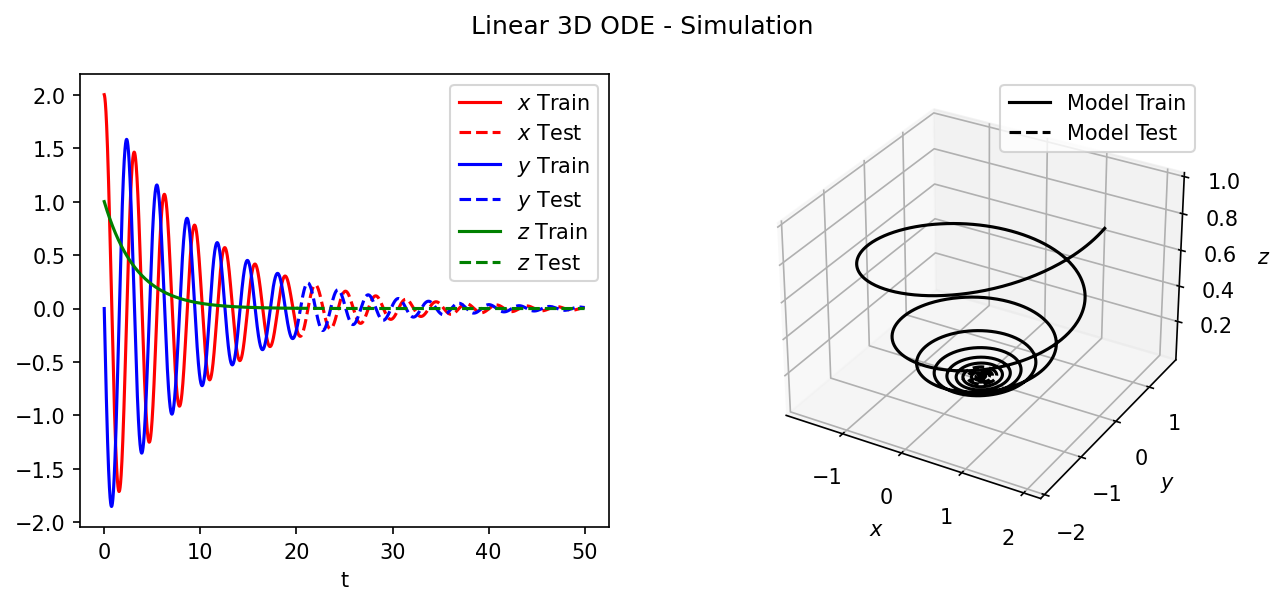

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 3D ODE - Simulation')
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [17]:
# Define SINDy Model
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.01),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['x', 'y', 'z']
)
# Fit and print resulting model
sindy_model.fit(x_train, t=t_train, quiet=True)
sindy_model.print()

# Simulate SINDy on the test data
x_sim = sindy_model.simulate(x_test[0], t_test)

x' = -0.100 x + 2.000 y
y' = -2.000 x + -0.100 y
z' = -0.300 z


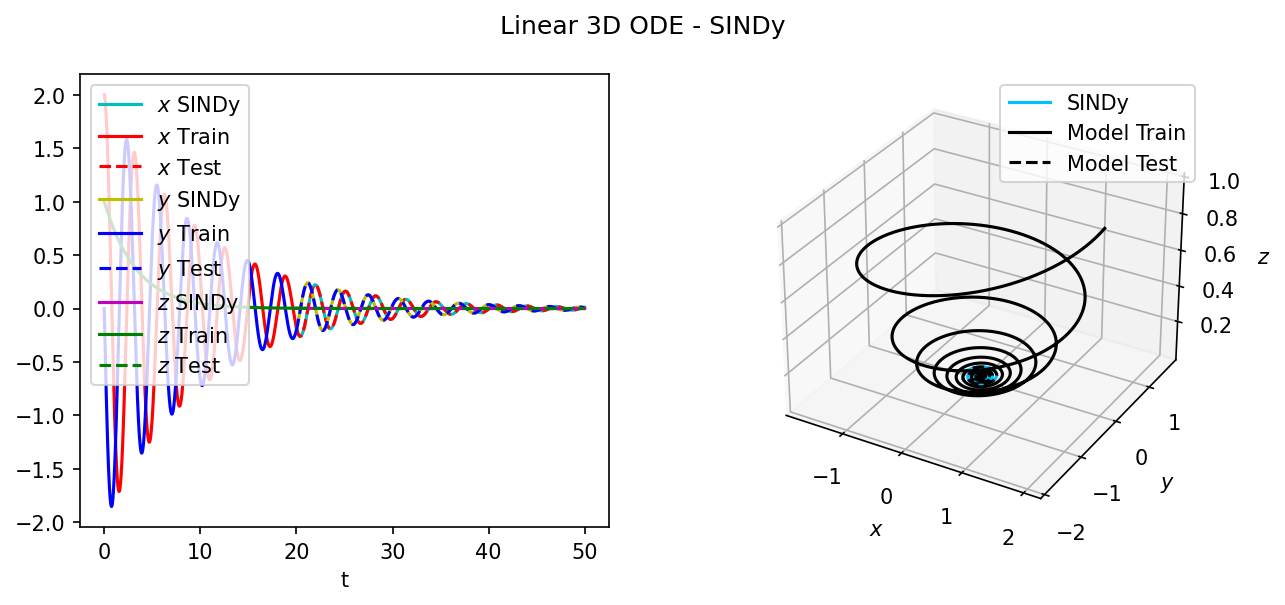

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 3D ODE - SINDy')
axs[0].plot(t_test, x_sim[:, 0], "c", label="$x$ SINDy")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, x_sim[:, 1], "y", label="$y$ SINDy")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_test, x_sim[:, 2], "m", label="$z$ SINDy")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "deepskyblue", label="SINDy")
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [19]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
narmax_model = FROLS(
    n_terms=2,
    ylag=1, xlag=[[1],[1]],
    estimator='least_squares',
    basis_function=Polynomial(degree=5)
)
narmax_model.fit(X=x_train[:-1,:2], y=x_train[1:,2].reshape(-1, 1))
r = pd.DataFrame(results(
    narmax_model.final_model, narmax_model.theta, narmax_model.err,
    narmax_model.n_terms, err_precision=8, dtype='sci'), columns=['Regressors', 'Parameters', 'ERR'])
print('Regressors Z')
print(r)
x_sim_z = narmax_model.predict(X=x_test[:,:2], y=x_test[0,2].reshape(-1, 1))

narmax_model.fit(X=x_train[:-1,[0,2]], y=x_train[1:,1].reshape(-1, 1))
r = pd.DataFrame(results(
    narmax_model.final_model, narmax_model.theta, narmax_model.err,
    narmax_model.n_terms, err_precision=8, dtype='sci'), columns=['Regressors', 'Parameters', 'ERR'])
print('Regressors Y')
print(r)
x_sim_y = narmax_model.predict(X=x_test[:,[0,2]], y=x_test[0,1].reshape(-1, 1))

narmax_model.fit(X=x_train[:-1,1:], y=x_train[1:,0].reshape(-1, 1))
r = pd.DataFrame(results(
    narmax_model.final_model, narmax_model.theta, narmax_model.err,
    narmax_model.n_terms, err_precision=8, dtype='sci'), columns=['Regressors', 'Parameters', 'ERR'])
print('Regressors X')
print(r)
x_sim_x = narmax_model.predict(X=x_test[:,1:], y=x_test[0,0].reshape(-1, 1))

x_sim = np.hstack((x_sim_x, x_sim_y, x_sim_z))

Regressors Z
                 Regressors   Parameters             ERR
0                    y(k-1)   9.9700E-01  1.00000000E+00
1  x2(k-1)^2x1(k-1)^2y(k-1)  -6.4339E-16  7.23990874E-31
Regressors Y
  Regressors   Parameters             ERR
0     y(k-1)   9.9840E-01  9.99601423E-01
1    x1(k-1)  -1.9963E-02  3.98577042E-04
Regressors X
  Regressors  Parameters             ERR
0     y(k-1)  9.9840E-01  9.99600768E-01
1    x1(k-1)  1.9963E-02  3.99231939E-04


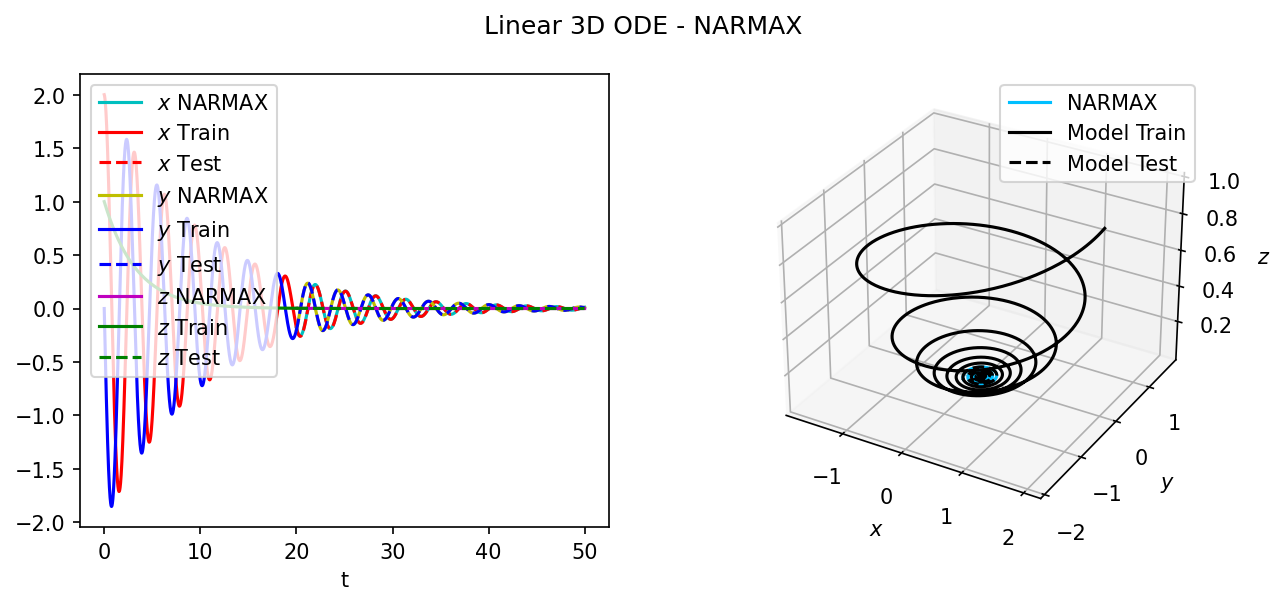

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Linear 3D ODE - NARMAX')
axs[0].plot(t_test, x_sim[:, 0], "c", label="$x$ NARMAX")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, x_sim[:, 1], "y", label="$y$ NARMAX")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_test, x_sim[:, 2], "m", label="$z$ NARMAX")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "deepskyblue", label="NARMAX")
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [ ]:
# Metrics (PENDING!!!)

$$\Large\text{Lorenz System}\newline\large \begin{split} \dot{x} & = \sigma(y-x)\\\dot{y} & = x(\rho - z) - y\\\dot{z} & = xy-\beta z\end{split}\newline\sigma = 10 \qquad \rho = 28 \qquad \beta = \frac{8}{3}$$

In [21]:
# Lorenz System
sigma = 10
rho = 28
beta = 8/3

def lorenz(x, t):
    return [sigma * (x[1] - x[0]),
            x[0] * (rho - x[2]) - x[1],
            x[0] * x[1] - beta * x[2]]

t = np.arange(0, 25, 0.001)
x = odeint(lorenz, [-8, 8, 27], t)

# Split Gnerated Data into Train-Test
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.75, shuffle=False)

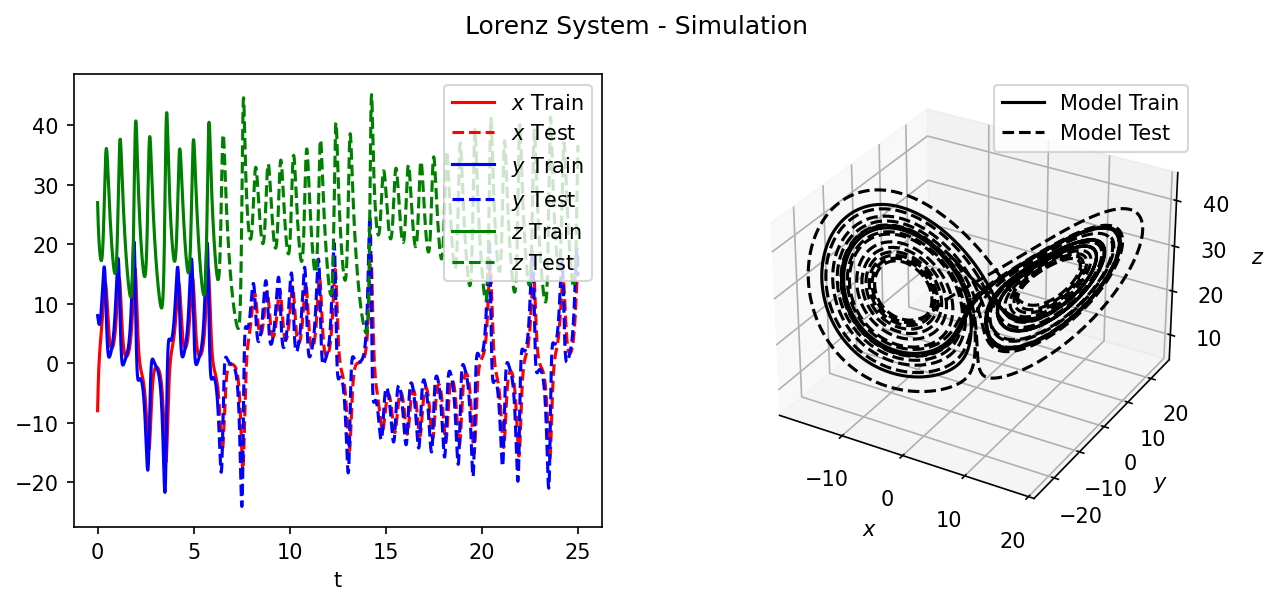

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Lorenz System - Simulation')
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [23]:
# Define SINDy Model
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.01),
    feature_library=ps.PolynomialLibrary(degree=5),
    feature_names=['x', 'y', 'z']
)
# Fit and print resulting model
sindy_model.fit(x_train, t=t_train, quiet=True)
sindy_model.print()

# Simulate SINDy on the test data
x_sim = sindy_model.simulate(x_test[0], t_test)

x' = -10.000 x + 10.000 y
y' = 27.998 x + -1.000 y + -1.000 x z
z' = -2.667 z + 1.000 x y


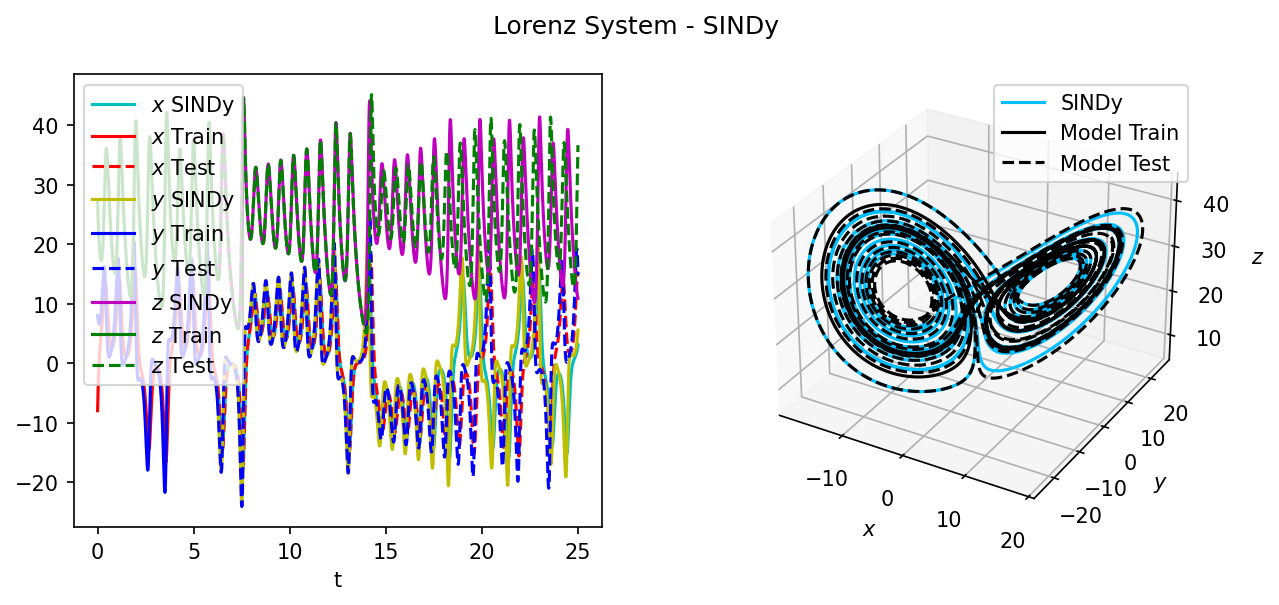

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Lorenz System - SINDy')
axs[0].plot(t_test, x_sim[:, 0], "c", label="$x$ SINDy")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, x_sim[:, 1], "y", label="$y$ SINDy")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_test, x_sim[:, 2], "m", label="$z$ SINDy")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "deepskyblue", label="SINDy")
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [25]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
narmax_model = FROLS(
    n_terms=7,
    ylag=1, xlag=[[1],[1]],
    estimator='least_squares',
    basis_function=Polynomial(degree=5)
)
narmax_model.fit(X=x_train[:-1,:2], y=x_train[1:,2].reshape(-1, 1))
r = pd.DataFrame(results(
    narmax_model.final_model, narmax_model.theta, narmax_model.err,
    narmax_model.n_terms, err_precision=8, dtype='sci'), columns=['Regressors', 'Parameters', 'ERR'])
print('Regressors Z')
print(r)
x_sim_z = narmax_model.predict(X=x_test[:,:2], y=x_test[0,2].reshape(-1, 1))

narmax_model.fit(X=x_train[:-1,[0,2]], y=x_train[1:,1].reshape(-1, 1))
r = pd.DataFrame(results(
    narmax_model.final_model, narmax_model.theta, narmax_model.err,
    narmax_model.n_terms, err_precision=8, dtype='sci'), columns=['Regressors', 'Parameters', 'ERR'])
print('Regressors Y')
print(r)
x_sim_y = narmax_model.predict(X=x_test[:,[0,2]], y=x_test[0,1].reshape(-1, 1))

narmax_model.fit(X=x_train[:-1,1:], y=x_train[1:,0].reshape(-1, 1))
r = pd.DataFrame(results(
    narmax_model.final_model, narmax_model.theta, narmax_model.err,
    narmax_model.n_terms, err_precision=8, dtype='sci'), columns=['Regressors', 'Parameters', 'ERR'])
print('Regressors X')
print(r)
x_sim_x = narmax_model.predict(X=x_test[:,1:], y=x_test[0,0].reshape(-1, 1))

x_sim = np.hstack((x_sim_x, x_sim_y, x_sim_z))

Regressors Z
             Regressors   Parameters             ERR
0                y(k-1)   9.9734E-01  9.99989522E-01
1        x2(k-1)x1(k-1)   9.9345E-04  1.04738314E-05
2     x1(k-1)^2y(k-1)^2  -1.5047E-08  3.49090418E-09
3             x2(k-1)^2   1.6147E-05  2.65748316E-10
4             x1(k-1)^4  -7.8362E-09  4.71695243E-11
5  x2(k-1)x1(k-1)y(k-1)  -3.2972E-07  1.33359300E-12
6             x1(k-1)^2   8.4039E-06  2.77132137E-12
Regressors Y
         Regressors   Parameters             ERR
0            y(k-1)   9.9910E-01  9.99946027E-01
1  x2(k-1)x1(k-1)^3  -9.7080E-08  5.07665525E-05
2         x1(k-1)^5   6.9133E-10  8.22081816E-07
3     x2(k-1)y(k-1)  -2.3493E-06  1.21579877E-06
4  x2(k-1)^4x1(k-1)   3.6228E-10  4.19627440E-07
5           x1(k-1)   2.8035E-02  1.86338532E-07
6    x2(k-1)x1(k-1)  -1.0030E-03  5.62441179E-07
Regressors X
        Regressors   Parameters             ERR
0           y(k-1)   9.9047E-01  9.99966128E-01
1          x1(k-1)   9.9343E-03  3.38638963E-05
2

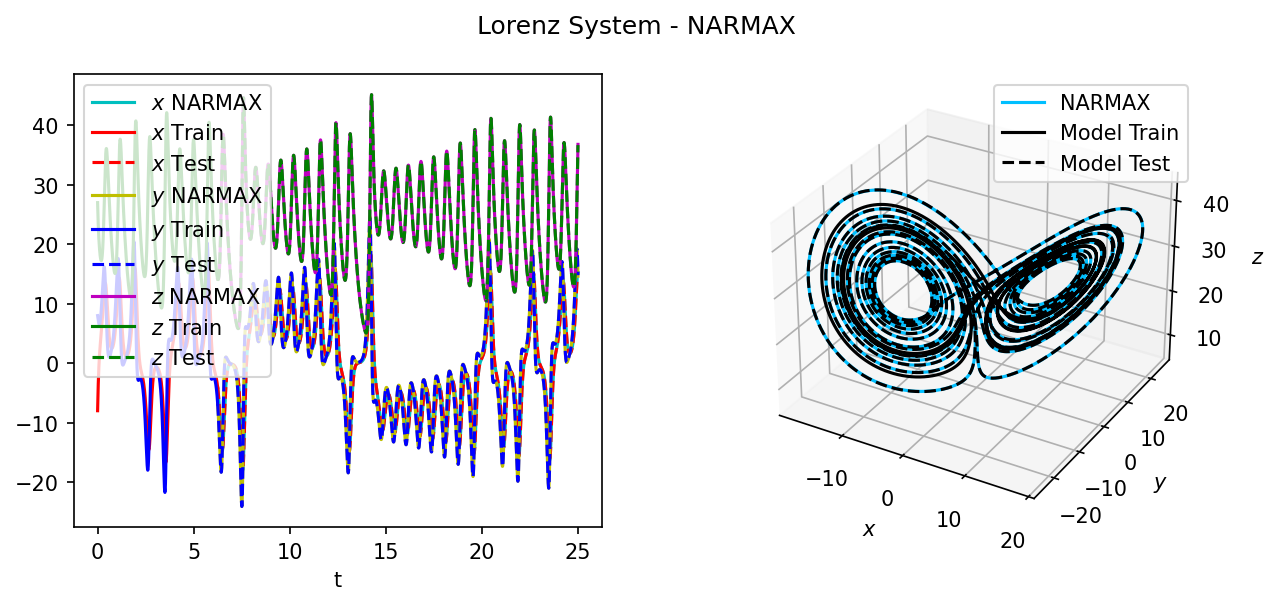

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
fig.suptitle('Lorenz System - NARMAX')
axs[0].plot(t_test, x_sim[:, 0], "c", label="$x$ NARMAX")
axs[0].plot(t_train, x_train[:, 0], "r", label="$x$ Train")
axs[0].plot(t_test, x_test[:, 0], "r--", label="$x$ Test")
axs[0].plot(t_test, x_sim[:, 1], "y", label="$y$ NARMAX")
axs[0].plot(t_train, x_train[:, 1], "b", label="$y$ Train")
axs[0].plot(t_test, x_test[:, 1], "b--", label="$y$ Test")
axs[0].plot(t_test, x_sim[:, 2], "m", label="$z$ NARMAX")
axs[0].plot(t_train, x_train[:, 2], "g", label="$z$ Train")
axs[0].plot(t_test, x_test[:, 2], "g--", label="$z$ Test")
axs[0].set(xlabel="t")
axs[0].legend()
axs[1] = plt.subplot(122, projection='3d')
axs[1].plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "deepskyblue", label="NARMAX")
axs[1].plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], "k", label="Model Train")
axs[1].plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], "k--", label="Model Test")
axs[1].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axs[1].legend()
print(end='')

In [ ]:
# Metrics (PENDING!!!)